# Episodically Diminishing Step Size

Solved after 353 episodes.


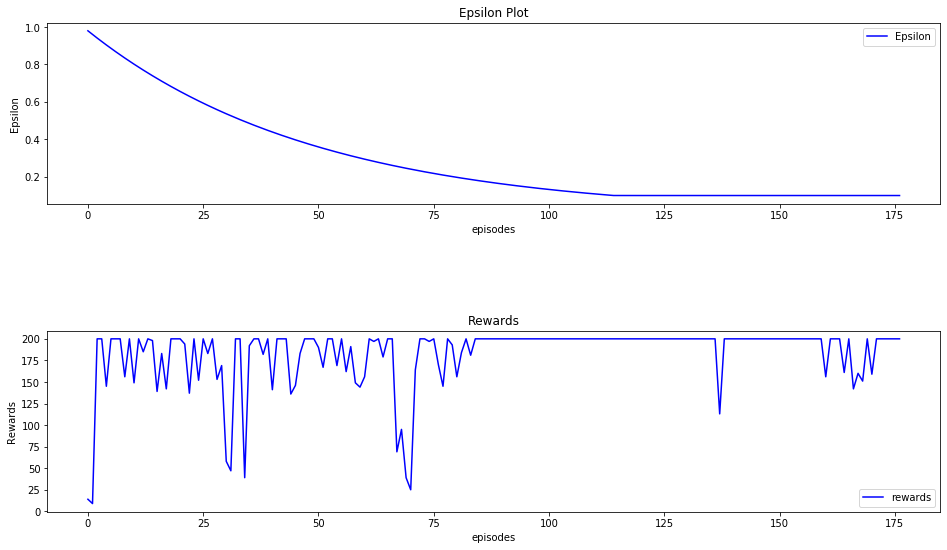

In [8]:
#initialized with random values:
#When initialized with random values it does not converge all the time, but a fair amount of the time

import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
from queue import Queue
env = gym.make('CartPole-v0')
#having a min epsilon of 0.1 makes sure that no matter what there is some exploration so that if the epsilon decays too fast the enviornment is not dependent on its previous knowledge
class Qlearning:
    def __init__(self,bins=(1, 1, 6, 12), max_episodes = 1000, max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> number of buckets for each action space
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.alpha = 1.0 # learning rate parameter
        self.beta = 0.5 # learning rate parameter
        self.epsilon = epsilon # exploration rate
        self.min_alpha = min_alpha
        self.min_epsilon = min_epsilon 
        self.solved = solved
        self.gamma = gamma
        self.decay = decay  #works for most numbers between 5 and 35
        self.action_space = action_space
        #print((self.action_space,))
        self.env = gym.make('CartPole-v0')
        self.QTable = np.random.randint(0, 66, size =(self.bins + (self.action_space,))) #The Q-matrix has now a dimension of (1 x 1 x 6 x 12 x 2).
        
    def discretize(self, state):
        upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)] 
        lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
        descretizedList = list()
        for i in  range(len(state)): 
            ratios = (state[i] + abs(upper_bounds[i])) / (upper_bounds[i] - lower_bounds[i])
            new_obs = int(round((self.bins[i] - 1) * ratios))
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) 
            descretizedList.append(new_obs)
        return tuple(descretizedList)

    def action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        if np.random.random() <= epsilon:
            action = self.env.action_space.sample()   
        else:
            action = np.argmax(self.QTable[state])  # exploitation
         return action
    
    def action_policy(self, state, policy):
        return policy[state]

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])

    def decay_epsilon(self):
        epsilon = self.epsilon * 0.99
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon 
    
    def decay_step_size(self, t):
        num = self.alpha
        dem = t**self.beta
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = num / dem  
        return step_size
    
#1-ln(time unit/decay)
    def learning(self):
        listof100 = deque(maxlen=100) #https://stackoverflow.com/questions/5944708/python-forcing-a-list-to-a-fixed-size
        rewards = []
        alphaList = []
        epsilonList = []
        for e in range(self.max_episodes):  
            state = self.env.reset()
            state = self.discretize(state)
            epsilon = self.decay_epsilon() #e)
            step_size = 1 #self.decay_step_size(e)
            i = 0
            for t in range(self.max_steps):
                step_size = self.decay_step_size(t)
                if e%2==0:
                    action = self.action(state, epsilon)
                elif e%2==1:
                    action = self.action_policy(state, policy)
                new_state, reward, done, info = self.env.step(action)
                new_state = self.discretize(new_state)
                self.Q_Update(state, action, reward, new_state, step_size)
                state = new_state
                i += 1
                if done:
                    break
            stateTuple = list()
            stateList = []
            actionsList = []
            states = []
            for list1 in self.QTable:
                for nextList in list1:
                    for nextList1 in nextList:
                        for nextList2 in nextList1:
                            actions = np.argmax(nextList2)
                            actionsList.append(actions)
            observations = np.argwhere(self.QTable>=0)
            j = 0
            for obsList in observations:
                stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3])
                stateList.append(stateTuple)
            del stateList[1::2]
            policy = dict(zip(stateList, actionsList))
            if e%2==1:
                listof100.append(i)
                mean_listof100 = np.mean(listof100)
                rewards.append(i)
                alphaList.append(step_size)
                epsilonList.append(epsilon)
                mean_rewards =  np.mean(rewards)
                if mean_listof100 >= 195 and e >= 100:
                    print("Solved after " + str(e) + " episodes.")
                    #print(self.QTable)
                    return rewards, alphaList, epsilonList
        print("Did not converge within the given time frame")
        return rewards, alphaList, epsilonList
    

if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    rewards, alpha, epsilon = solve.learning()
    fig = plt.figure(figsize=(16,9))
    ax1 = fig.add_subplot(211)
    ax1.plot(epsilon,  # epsilon_hist,
             color='b',
             label='Epsilon')
    ax1.set(title='Epsilon Plot',
            ylabel='Epsilon',
            xlabel='episodes')
    #ax2 = fig.add_subplot(212)
    """x2.plot(alpha,  # epsilon_hist,
             color='b',
             label='step size')
    ax2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')"""
    ax3 = fig.add_subplot(212)
    ax3.plot(rewards,  # epsilon_hist,
             color='b',
             label='rewards')
    ax3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')
    fig.subplots_adjust(hspace=0.7)
    ax1.legend(loc='best')
    #ax2.legend(loc='best')
    ax3.legend(loc='best')

    plt.show()


# Constant Step Size

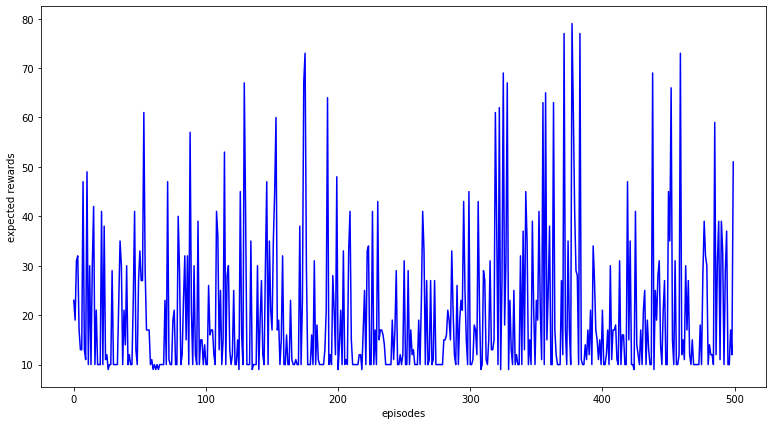

In [16]:
# I attempted 100 different values for alpha from 0.001 to 0.100 - none of them convereged
# I tried this for two epsilon functions: the natural log function decay, and constant decay

import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
env = gym.make('CartPole-v0')
class Qlearning():
    def __init__(self,bins=(1, 1, 6, 12), max_episodes = 1000, max_steps = 195, alpha=0.095, min_epsilon=0.1, epsilon = 1.0, gamma = 0.9 , decay = 25, solved=False, action_space = env.action_space.n):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> number of buckets for each action space
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.alpha = alpha # learning rate
        self.solved = solved
        self.epsilon = 1.0
        self.min_epsilon = min_epsilon  
        self.gamma = gamma
        self.decay = decay
        self.action_space = action_space
        self.env = gym.make('CartPole-v0')
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q-matrix has now a dimension of (1 x 1 x 6 x 12 x 2).

    def discretize(self, state):
        upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]  
        lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
        descretizedList = list()
        for i in  range(len(state)): 
            ratios = (state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) 
            new_obs = int(round((self.bins[i] - 1) * ratios)) 
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) 
            descretizedList.append(new_obs)
        return tuple(descretizedList)

    def action(self, state,epsilon):
        if np.random.random() <= epsilon:
            action = self.env.action_space.sample()   
        else:
            action = np.argmax(self.QTable[state])  # exploitation
        return action

    def action_policy(self, state, policy):
        return policy[state]
    
    def Q_Update(self, state, action, reward, new_state, alpha):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += alpha * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        return
       
    # Updating Q-value of state-action pair based on the update equation - exploration rate
    def decay_epsilon(self):
        epsilon = self.epsilon * 0.99
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon

    def learning(self):
        rewards = []
        alphaList = []
        epsilonList = []
        for e in range(self.max_episodes):  
            state = self.discretize(self.env.reset())
            epsilon = self.decay_epsilon()
            alpha = self.alpha
            i = 0
            for t in range(self.max_steps):
                if e%2==0:
                    action = self.action(state, epsilon)
                elif e%2==1:
                    action = self.action_policy(state, policy)
                new_state, reward, done, info = self.env.step(action)
                new_state = self.discretize(new_state)
                self.Q_Update(state, action, reward, new_state, alpha)
                state = new_state
                i += 1
                if done:
                    break
            stateTuple = list()
            stateList = []
            actionsList = []
            states = []
            for list1 in self.QTable:
                for nextList in list1:
                    for nextList1 in nextList:
                        for nextList2 in nextList1:
                            actions = np.argmax(nextList2)
                            actionsList.append(actions)
            observations = np.argwhere(self.QTable>=0)
            j = 0
            for obsList in observations:
                stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3])
                stateList.append(stateTuple)
            del stateList[1::2]
            policy = dict(zip(stateList, actionsList))
            if e%2==1:
                rewards.append(i)
                alphaList.append(alpha)
                epsilonList.append(epsilon)
                mean_rewards =  np.mean(rewards)
                if mean_rewards >= self.max_steps and e > 100:
                    return rewards
        return rewards, alphaList, epsilonList

if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    rewards, alpha, epsilon  = solve.learning()
    plt.figure(figsize=(13,7))
    plt.plot(rewards, 
            color = 'b')
    plt.xlabel('episodes')
    plt.ylabel('expected rewards') 
    plt.show()

# Continually Diminishing

Did not converge within the given time frame


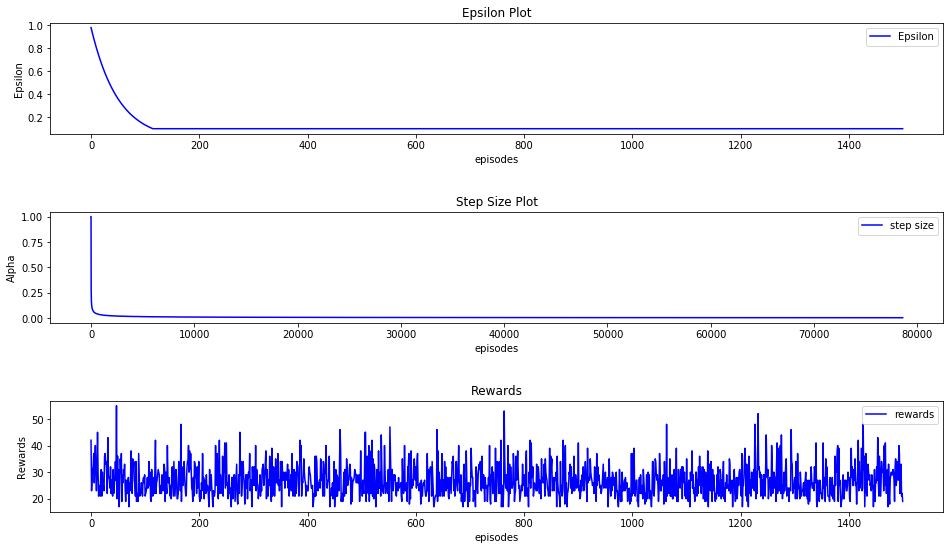

In [1]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
from queue import Queue
env = gym.make('CartPole-v0')
#having a min epsilon of 0.1 makes sure that no matter what there is some exploration so that if the epsilon decays too fast the enviornment is not dependent on its previous knowledge
class Qlearning:
    def __init__(self,bins=(1, 1, 6, 12), max_episodes = 3000, max_steps = 195,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> number of buckets for each action space
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.alpha = 1.0 # learning rate parameter
        self.beta = 0.5 # learning rate parameter
        self.epsilon = epsilon # exploration rate
        self.min_alpha = min_alpha
        self.min_epsilon = min_epsilon 
        self.solved = solved
        self.gamma = gamma
        self.decay = decay  #works for most numbers between 5 and 35
        self.action_space = action_space
        self.env = gym.make('CartPole-v0')
        self.QTable = np.random.randint(0, 5, size =(self.bins + (self.action_space,))) #The Q-matrix has now a dimension of (1 x 1 x 6 x 12 x 2).
        #print(self.QTable)
        
    def discretize(self, state):
        upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]  #UNDERSTAND HOW THIS WORKS
        lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
        descretizedList = list()
        for i in  range(len(state)): #state = tuple (0,0,X,X)--> aka the state space  #scaling factor
            ratios = (state[i] + abs(upper_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) # (state+lower / bin_width) = bucket size
            new_obs = int(round((self.bins[i] - 1) * ratios)) #multiply the bucket size by the bucket # scaling the buckets so that the state is reduced#  - 1makes the first two buckets 0, and #bucket_lower := min_x + bucket × bucket size
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) 
            descretizedList.append(new_obs)
        return tuple(descretizedList)

    def action(self, state, epsilon):
         if np.random.random() <= epsilon:
            action = self.env.action_space.sample()   
        else:
            action = np.argmax(self.QTable[state])  # exploitation
        return action

    def action_policy(self, state, policy):
        return policy[state]
    
    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
    
    def decay_epsilon(self):
        epsilon = self.epsilon * 0.99
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon 
    
    def decay_step_size(self, tt, e, t):
        num = self.alpha
        dem = tt**self.beta
        if e == 0 and t == 0:
            step_size = 1
        elif tt > 0:
            step_size = num / dem
        return step_size
    
#1-ln(time unit/decay)
    def learning(self):
        listof100 = deque(maxlen=100) #https://stackoverflow.com/questions/5944708/python-forcing-a-list-to-a-fixed-size
        rewards = []
        alphaList = []
        epsilonList = []
        tt = 0
        for e in range(self.max_episodes):  
            state = self.discretize(self.env.reset())
            epsilon = self.decay_epsilon() #e)
            i = 0
            for t in range(self.max_steps):
                step_size = self.decay_step_size(tt, e, t)
                tt += 1
                if e%2==0:
                    action = self.action(state, epsilon)
                elif e%2==1:
                    action = self.action_policy(state, policy)
                new_state, reward, done, info = self.env.step(action)
                new_state = self.discretize(new_state)
                self.Q_Update(state, action, reward, new_state, step_size)
                state = new_state
                i += 1
                alphaList.append(step_size)
                if done:
                    break
            stateTuple = list()
            stateList = []
            actionsList = []
            states = []
            for list1 in self.QTable:
                for nextList in list1:
                    for nextList1 in nextList:
                        for nextList2 in nextList1:
                            actions = np.argmax(nextList2)
                            actionsList.append(actions)
            observations = np.argwhere(self.QTable>=0)
            j = 0
            for obsList in observations:
                stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3])
                stateList.append(stateTuple)
            del stateList[1::2]
            policy = dict(zip(stateList, actionsList))
            if e%2==1:
                listof100.append(i)
                mean_listof100 = np.mean(listof100)
                rewards.append(i)
                epsilonList.append(epsilon)
                mean_rewards =  np.mean(rewards)
                if mean_listof100 >= self.max_steps and e >= 100:
                    print("Solved after " + str(e) + " episodes.")
                    return rewards, alphaList, epsilonList
        print("Did not converge within the given time frame")
        
        return rewards, alphaList, epsilonList

if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    rewards, alpha, epsilon = solve.learning()
    fig = plt.figure(figsize=(16,9))
    ax1 = fig.add_subplot(311)
    ax1.plot(epsilon,  # epsilon_hist,
             color='b',
             label='Epsilon')
    ax1.set(title='Epsilon Plot',
            ylabel='Epsilon',
            xlabel='episodes')
    ax2 = fig.add_subplot(312)
    ax2.plot(alpha,  # epsilon_hist,
             color='b',
             label='step size')
    ax2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')
    ax3 = fig.add_subplot(313)
    ax3.plot(rewards,  # epsilon_hist,
             color='b',
             label='rewards')
    ax3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')
    fig.subplots_adjust(hspace=0.7)
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    ax3.legend(loc='best')

    plt.show()

    
    #plt.plot(alpha)
    #plt.xlabel('episodes')
    #plt.ylabel('rewards') 
    #plt.show()

# Restarting Diminishing: QTable Initialized Randomly

Solved after 169 episodes.


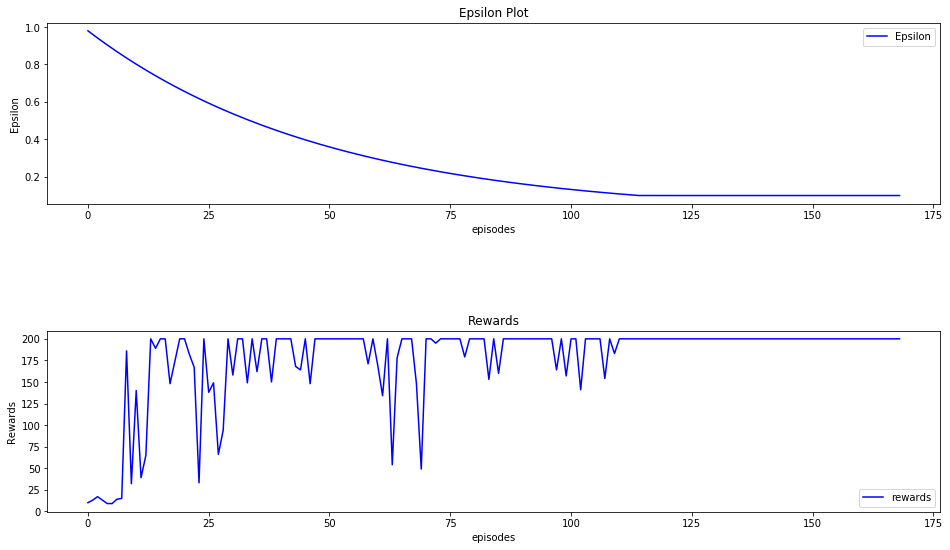

In [4]:
#initialized with random values:
#When initialized with random values it does not converge all the time, but a fair amount of the time

import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
from queue import Queue
env = gym.make('CartPole-v0')
#having a min epsilon of 0.1 makes sure that no matter what there is some exploration so that if the epsilon decays too fast the enviornment is not dependent on its previous knowledge
class Qlearning:
    def __init__(self,bins=(1, 1, 6, 12), max_episodes = 2500, max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> number of buckets for each action space
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.alpha = 1.0 # learning rate parameter
        self.beta = 0.5 # learning rate parameter
        self.epsilon = epsilon # exploration rate
        self.min_alpha = min_alpha
        self.min_epsilon = min_epsilon 
        self.solved = solved
        self.gamma = gamma
        self.decay = decay  #works for most numbers between 5 and 35
        self.action_space = action_space
        self.env = gym.make('CartPole-v0')
        self.QTable = np.random.randint(0, 66, size =(self.bins + (self.action_space,))) #The Q-matrix has now a dimension of (1 x 1 x 6 x 12 x 2).
        
    def discretize(self, state):
        upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]  
        lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
        descretizedList = list()
        for i in  range(len(state)): 
            ratios = (state[i] + abs(upper_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) 
            new_obs = int(round((self.bins[i] - 1) * ratios))
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) 
            descretizedList.append(new_obs)
        return tuple(descretizedList)

    def action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        if np.random.random() <= epsilon:
            action = self.env.action_space.sample()   
        else:
            action = np.argmax(self.QTable[state])  # exploitation
        return action

    def action_policy(self, state, policy):
        return policy[state]
    
    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
    
    def decay_epsilon(self):
        epsilon = self.epsilon * 0.99
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon 
    
    def decay_step_size(self, t):
        num = self.alpha
        dem = t**self.beta
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = num / dem  
        return step_size
    
#1-ln(time unit/decay)
    def learning(self):
        listof100 = deque(maxlen=100) #https://stackoverflow.com/questions/5944708/python-forcing-a-list-to-a-fixed-size
        rewards = []
        alphaList = []
        epsilonList = []
        for e in range(self.max_episodes):  
            state = self.discretize(self.env.reset())
            epsilon = self.decay_epsilon() #e)
            #step_size = 1 #self.decay_step_size(e)
            i = 0
            for t in range(self.max_steps):
                step_size = self.decay_step_size(t)
                if e%2==0:
                    action = self.action(state, epsilon)
                elif e%2==1:
                    action = self.action_policy(state, policy)
                new_state, reward, done, info = self.env.step(action)
                new_state = self.discretize(new_state)
                self.Q_Update(state, action, reward, new_state, step_size)
                state = new_state
                i += 1
                if done:
                    break
            stateTuple = list()
            stateList = []
            actionsList = []
            states = []
            for list1 in self.QTable:
                for nextList in list1:
                    for nextList1 in nextList:
                        for nextList2 in nextList1:
                            actions = np.argmax(nextList2)
                            actionsList.append(actions)
            observations = np.argwhere(self.QTable>=0)
            j = 0
            for obsList in observations:
                stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3])
                stateList.append(stateTuple)
            del stateList[1::2]
            policy = dict(zip(stateList, actionsList))
            if e%2==1:
                listof100.append(i)
                mean_listof100 = np.mean(listof100)
                rewards.append(i)
                epsilonList.append(epsilon)
                mean_rewards =  np.mean(rewards)
                if mean_listof100 >= 195 and e >= 100:
                    print("Solved after " + str(len(rewards)) + " episodes.")
                    return rewards, alphaList, epsilonList
        print("Did not converge within the given time frame")
        return rewards, alphaList, epsilonList



if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    rewards, alpha, epsilon = solve.learning()
    fig = plt.figure(figsize=(16,9))
    ax1 = fig.add_subplot(211)
    ax1.plot(epsilon,  # epsilon_hist,
             color='b',
             label='Epsilon')
    ax1.set(title='Epsilon Plot',
            ylabel='Epsilon',
            xlabel='episodes')
    #ax2 = fig.add_subplot(212)
    """x2.plot(alpha,  # epsilon_hist,
             color='b',
             label='step size')
    ax2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')"""
    ax3 = fig.add_subplot(212)
    ax3.plot(rewards,  # epsilon_hist,
             color='b',
             label='rewards')
    ax3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')
    fig.subplots_adjust(hspace=0.7)
    ax1.legend(loc='best')
    #ax2.legend(loc='best')
    ax3.legend(loc='best')

    plt.show()

# Restarting Diminishing: QTable Initialized with Zeros

Solved after 269 episodes.


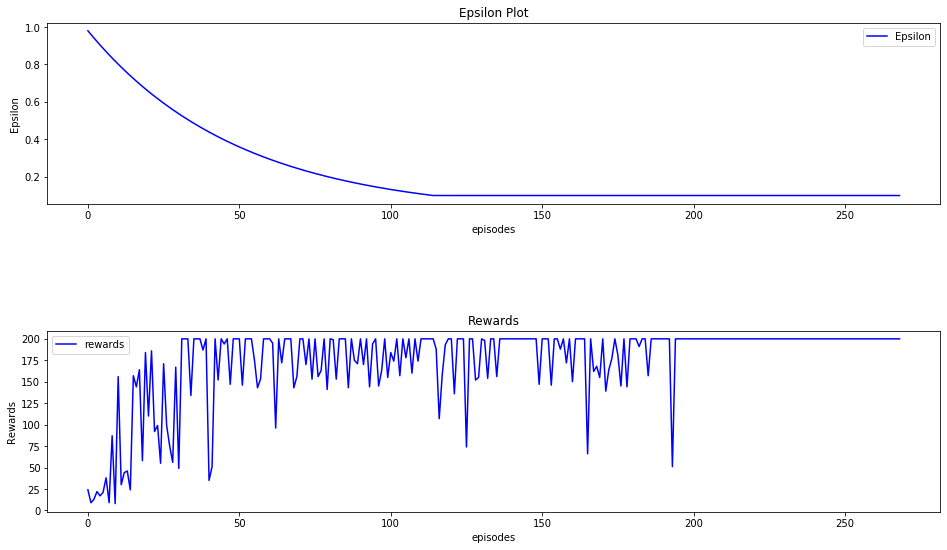

In [6]:
#initialized with random values:
#When initialized with random values it does not converge all the time, but a fair amount of the time

import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
from queue import Queue
env = gym.make('CartPole-v0')
#having a min epsilon of 0.1 makes sure that no matter what there is some exploration so that if the epsilon decays too fast the enviornment is not dependent on its previous knowledge

class Qlearning:
    def __init__(self,bins=(1, 1, 6, 12), max_episodes = 2500, max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> number of buckets for each action space
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.alpha = 1.0 # learning rate parameter
        self.beta = 0.5 # learning rate parameter
        self.epsilon = epsilon # exploration rate
        self.min_alpha = min_alpha
        self.min_epsilon = min_epsilon 
        self.solved = solved
        self.gamma = gamma
        self.decay = decay  #works for most numbers between 5 and 35
        self.action_space = action_space
        self.env = gym.make('CartPole-v0')
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q-matrix has now a dimension of (1 x 1 x 6 x 12 x 2).
        
    def discretize(self, state):
        upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]  #UNDERSTAND HOW THIS WORKS
        lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
        descretizedList = list()
        for i in  range(len(state)): 
            ratios = (state[i] + abs(upper_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) 
            new_obs = int(round((self.bins[i] - 1) * ratios))
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) 
            descretizedList.append(new_obs)
        return tuple(descretizedList)

    def action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        if np.random.random() <= epsilon:
            action = self.env.action_space.sample()   
        else:
            action = np.argmax(self.QTable[state])  # exploitation
        return action

    def action_policy(self, state, policy):
        return policy[state]
    
    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])

    def decay_epsilon(self):
        epsilon = self.epsilon * 0.99
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon 
    
    def decay_step_size(self, t):
        num = self.alpha
        dem = t**self.beta
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = num / dem  
        return step_size
    
#1-ln(time unit/decay)
    def learning(self):
        listof100 = deque(maxlen=100) #https://stackoverflow.com/questions/5944708/python-forcing-a-list-to-a-fixed-size
        rewards = []
        alphaList = []
        epsilonList = []
        for e in range(self.max_episodes):  
            state = self.discretize(self.env.reset())
            epsilon = self.decay_epsilon() #e)
            #step_size = 1 #self.decay_step_size(e)
            i = 0
            for t in range(self.max_steps):
                step_size = self.decay_step_size(t)
                if e%2==0:
                    action = self.action(state, epsilon)
                elif e%2==1:
                    action = self.action_policy(state, policy)
                new_state, reward, done, info = self.env.step(action)
                #print(new_state)
                new_state = self.discretize(new_state)
                self.Q_Update(state, action, reward, new_state, step_size)
                state = new_state
                i += 1
                if done:
                    break
            stateTuple = list()
            stateList = []
            actionsList = []
            states = []
            for list1 in self.QTable:
                for nextList in list1:
                    for nextList1 in nextList:
                        for nextList2 in nextList1:
                            actions = np.argmax(nextList2)
                            actionsList.append(actions)
            observations = np.argwhere(self.QTable>=0)
            j = 0
            for obsList in observations:
                stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3])
                stateList.append(stateTuple)
            del stateList[1::2]
            policy = dict(zip(stateList, actionsList))
            if e%2==1:
                listof100.append(i)
                mean_listof100 = np.mean(listof100)
                rewards.append(i)
                epsilonList.append(epsilon)
                mean_rewards =  np.mean(rewards)
                if mean_listof100 >= 195 and e >= 100:
                    print("Solved after " + str(len(rewards)) + " episodes.")
                    return rewards, alphaList, epsilonList
        print("Did not converge within the given time frame")
        return rewards, alphaList, epsilonList
    

if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    rewards, alpha, epsilon = solve.learning()
    fig = plt.figure(figsize=(16,9))
    ax1 = fig.add_subplot(211)
    ax1.plot(epsilon,  # epsilon_hist,
             color='b',
             label='Epsilon')
    ax1.set(title='Epsilon Plot',
            ylabel='Epsilon',
            xlabel='episodes')
    #ax2 = fig.add_subplot(212)
    """x2.plot(alpha,  # epsilon_hist,
             color='b',
             label='step size')
    ax2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')"""
    ax3 = fig.add_subplot(212)
    ax3.plot(rewards,  # epsilon_hist,
             color='b',
             label='rewards')
    ax3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')
    fig.subplots_adjust(hspace=0.7)
    ax1.legend(loc='best')
    #ax2.legend(loc='best')
    ax3.legend(loc='best')

    plt.show()